## Step 1: Env. setup

In [ ]:
# Hugging Face + Transformers
import re
from transformers import (
    AutoTokenizer, TFAutoModelForSeq2SeqLM, Trainer, TrainingArguments,
    DataCollatorForSeq2Seq, T5ForConditionalGeneration, EarlyStoppingCallback
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import evaluate  # for ROUGE

# Set the MPS memory limit environment variable for training memory
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"


#For evaluation
import random
from torch.utils.data import DataLoader


/opt/anaconda3/envs/tf_t5_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/tf_t5_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#For VSCode local training
import sys
import torch
print("Python executable:", sys.executable)
print("Torch version:", torch.__version__)
print("Torch location:", torch.__file__)

Python executable: /opt/anaconda3/envs/tf_t5_env/bin/python
Torch version: 2.6.0
Torch location: /opt/anaconda3/envs/tf_t5_env/lib/python3.10/site-packages/torch/__init__.py


## Step 2: Load and Explore the SAMSum dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("knkarthick/samsum")

#inspect size of train and test set
print(f"Train set size: {len(dataset['train'])}")
print(f"Test set size: {len(dataset['test'])}")
print(f"Validation set size: {len(dataset['validation'])}")

#preview
dataset["train"][0]

Train set size: 14731
Test set size: 819
Validation set size: 818


{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
#Check for N/A rows (None values in the dialogue field)
invalids = [i for i, example in enumerate(dataset['train']) if example['dialogue'] is None]
print("Invalid rows:", len(invalids))

Invalid rows: 1


In [ ]:
def inspect_dataset(dataset_split):
    lengths = [len(example['dialogue'].split())
    for example in dataset_split if example['dialogue'] is not None]
    print("Number of valid samples:", len(lengths))
    print("Avg dialogue length:", np.mean(lengths))
    print("Max length:", max(lengths))

inspect_dataset(dataset['train'])

Number of valide samples: 14731
Avg dialogue length: 93.79274998302898
Max length: 803


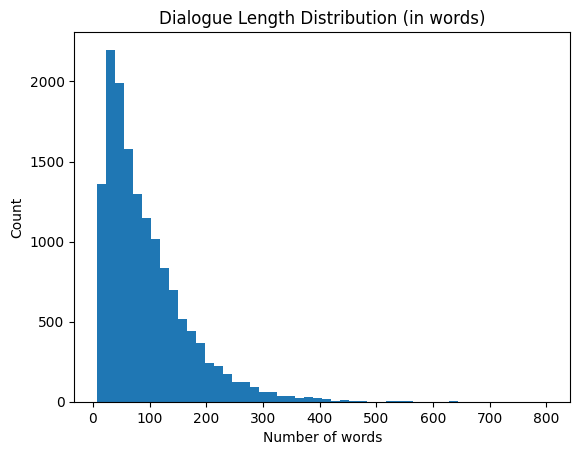

In [ ]:
#Check distribution of dialogue lengths
dialogue_lengths = [len(example['dialogue'].split()) for example in dataset['train'] if example['dialogue']]
plt.hist(dialogue_lengths, bins=50)
plt.title("Dialogue Length Distribution (in words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

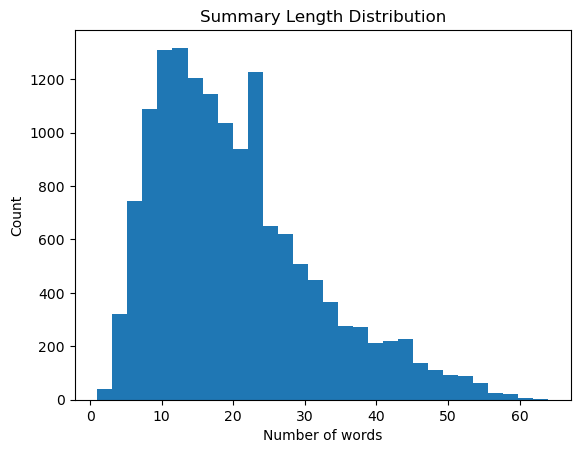

In [ ]:
#Check sumary lengths to help set max_target_lengths for decoder
summary_lengths = [len(example['summary'].split()) for example in dataset['train'] if example['summary']]
plt.hist(summary_lengths, bins=30)
plt.title("Summary Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

In [ ]:
#Check number of unique speakers for understand how complex the dialogues are
def count_speakers(dialogue):
    return len(set(re.findall(r"([A-Z][a-zA-Z]+):", dialogue)))

speaker_counts = [count_speakers(example['dialogue']) for example in dataset['train'] if example['dialogue']]
print("Average # of speakers per dialogue:", np.mean(speaker_counts))

Average # of speakers per dialogue: 2.3957640350281717


#### EDA Implications:
1. set max_input_length to 384 subword tokens to start (as most dialogues fall under 300 words with some outliers up to 800), optionally go to 1024 if needed
2. Set max_target_length for summaries to 96 subword tokens to start as most summaries are < 40 words, optionally go to 128 if needed.
3. ~2.4 speakers per dialogue means these are simple conversations, T5 can handle the context well without needing speaker embeddings or extra conditioning.

## Step 3: Data Preprocessing

### 3.1 For encoder-decoder models (T5-small)

In [ ]:
# Model and tokenizer
model_ckpt = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = T5ForConditionalGeneration.from_pretrained(model_ckpt)

# Lengths based on your histogram
max_input_length = 384
max_target_length = 96

def preprocess_function(examples):
    print(type(examples["dialogue"]))
    print(examples["dialogue"][:2])  # show first 2 dialogues
    inputs = ["summarize: " + str(d) for d in examples["dialogue"]]
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        examples["summary"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
#Filter dataset before .map
# Remove invalid entries (dialogue or summary is not a string)
def is_valid(example):
    return isinstance(example["dialogue"], str) and isinstance(example["summary"], str)

dataset = dataset.filter(is_valid)

In [ ]:
#Sanity check for broken types
bad_dialogue_count = sum(not isinstance(ex['dialogue'], str) for ex in dataset['train'])
bad_summary_count = sum(not isinstance(ex['summary'], str) for ex in dataset['train'])
print(f"Bad dialogues: {bad_dialogue_count}, Bad summaries: {bad_summary_count}")

Bad dialogues: 0, Bad summaries: 0


In [ ]:
# Apply to dataset
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["id", "dialogue", "summary"]  # keep only encoded fields
)

### 3.2 Applying preprocessing function to Train/test/Eval sets

In [ ]:
tokenized_datasets = {
    split: dataset[split].map(
      preprocess_function,
      batched=True,
      remove_columns=["id", "dialogue", "summary"]
  )
 for split in dataset}

# Access:
train_data = tokenized_datasets["train"]
eval_data = tokenized_datasets["validation"] #renamed validation to eval_data to match HF's Trainer convention
test_data = tokenized_datasets["test"]

## Step 4 Training Setup

### 4.1 Eval. Metric: ROGUE

In [ ]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = [[(l if l != -100 else tokenizer.pad_token_id) for l in label] for label in labels]
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Extract only rougeL, rouge1, rouge2
    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }

### 4.2 Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no", #disable for testing, return to "epoch" once tested
    save_strategy="no",
    logging_strategy="epoch",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,  # Added gradient accumulation for memory efficiency
    num_train_epochs=3,
    gradient_checkpointing=True, #test memory saver
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeL",
    greater_is_better=True
)

### 4.3 Data Collator and Trainer

In [ ]:
#Collator to handle padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/var/folders/8d/1x25d9h51tld47f1jk70zymh0000gn/T/ipykernel_38847/2830595579.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Step 6 Train the Model

In [ ]:
trainer.train()

Step,Training Loss
3683,0.629500
7366,0.587000
11049,0.572800


TrainOutput(global_step=11049, training_loss=0.5964281004644085, metrics={'train_runtime': 7735.9428, 'train_samples_per_second': 5.713, 'train_steps_per_second': 1.428, 'total_flos': 4485870174339072.0, 'train_loss': 0.5964281004644085, 'epoch': 3.0})

## Step 7 Evaluation

### 7.1 Fast evaluation with 200 samples from validation set

In [ ]:
#Fast evaluation:
from tqdm import tqdm
eval_split = tokenized_datasets["validation"]

#reduce size for faster testing
sample_size = 200 #change for speed vs. accuracy
eval_split_small = eval_split.select(range(sample_size))

#set eval mode and disable gradients
model.eval()
predictions = []
references = []

#create batches for speed
batch_size = 8
for i in tqdm(range(0, len(eval_split_small), batch_size)):
    batch = eval_split_small[i:i+batch_size]
    input_ids = torch.tensor(batch["input_ids"]).to(model.device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length,
            num_beams=4
        )

    # Decode predictions and references
    preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    labels = [
        [l if l != -100 else tokenizer.pad_token_id for l in label]
        for label in batch["labels"]
    ]
    refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

    predictions.extend(preds)
    references.extend(refs)

# Compute ROUGE
rouge_result = rouge.compute(predictions=predictions, references=references, use_stemmer=True)

# Show main scores
for key in ["rouge1", "rouge2", "rougeL"]:
    print(f"{key}: {rouge_result[key]:.4f}")

100%|██████████| 25/25 [30:38<00:00, 73.54s/it]


rouge1: 0.3523
rouge2: 0.1285
rougeL: 0.2883


In [ ]:
#Eyeball 20 examples

# Work with raw validation set (after filtering, before tokenization)
raw_val = dataset["validation"]

# Sample 20 random indices
sample_n = 20
indices = random.sample(range(len(raw_val)), sample_n)

for idx in indices:
    dialogue = raw_val[idx]["dialogue"]
    reference_summary = raw_val[idx]["summary"]

    # Tokenize dialogue for model input
    inputs = tokenizer(
        "summarize: " + dialogue,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True
    ).to(model.device)

    # Generate prediction
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_target_length,
            num_beams=4,
            no_repeat_ngram_size=3,
            min_length=16,
            early_stopping=True
        )

    predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"\n=== Example {idx} ===")
    print(f"[DIALOGUE]\n{dialogue}\n")
    print(f"[REFERENCE SUMMARY]\n{reference_summary}\n")
    print(f"[MODEL PREDICTION]\n{predicted_summary}")
    print("="*80)


=== Example 238 ===
[DIALOGUE]
Lucy: Who want to bet Eli is gonna lose to Steve?
Eli: Hey! where's your loyalty, Lucy?
Steve: There's no loyalty in bar games, Eli, you should know that. Oh, and I am gonna win
Eli: no freaking way. I will crush you!

[REFERENCE SUMMARY]
Lucy, Eli and Steve are going to participate in a bar game.

[MODEL PREDICTION]
Eli is gonna lose to Steve. There's no loyalty in bar games.

=== Example 517 ===
[DIALOGUE]
Carl: Hey guys, how about inviting me to dinner one of those days? 😹
Evelyn: LOL SURE THING. When would you like to be invited?
Carl: I'll let you choose
Evelyn: ha ha ha that's kind of you... Let me see... Would Thursday work for you? @Marek and for you? 😂
Marek: Thursday dinner at my place - sounds good. We might just as well invite Barbara, if you guys are ok with it (?)
Evelyn: Yeah, sure
Carl: Go for it. I'll call her asap AND bring some wine
Evelyn: Splendid
Marek: Well then, looking forward to it. What will we be cooking? 😅
Evelyn: We'll sort 

### 7.2 Random Search for best decoder configuration

In [ ]:
#random search for best decoder config
import time
from math import ceil

# --- Config ---
SAMPLE_SIZE   = 300   # how many validation examples to evaluate per config (speed vs. fidelity)
BATCH_SIZE    = 8
N_TRIALS      = 12    # number of random configurations to try
SEED          = 42

# Search spaces
BEAM_SPACE    = [2, 4, 6, 8]
LP_SPACE      = [0.9, 1.0, 1.1, 1.2, 1.3]
MINLEN_SPACE  = [12, 16, 20, 24, 28]

random.seed(SEED)
torch.set_grad_enabled(False)
model.eval()

# Use RAW validation to access original dialogue & reference summary
raw_val = dataset["validation"]

# Pre-sample a fixed subset for all trials (reduces variance across trials)
assert len(raw_val) > 0, "Validation split is empty."
subset_indices = random.sample(range(len(raw_val)), min(SAMPLE_SIZE, len(raw_val)))
sub_dialogues  = [raw_val[i]["dialogue"] for i in subset_indices]
sub_refs       = [raw_val[i]["summary"]  for i in subset_indices]

def evaluate_config(num_beams, length_penalty, min_length):
    """Run generation on the fixed subset and compute ROUGE."""
    # Batch tokenize inputs (faster than per-example)
    enc = tokenizer(
        ["summarize: " + d for d in sub_dialogues],
        max_length=max_input_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(model.device)
    attn_mask = enc["attention_mask"].to(model.device)

    # Batched generation
    preds = []
    n = input_ids.size(0)
    for start in range(0, n, BATCH_SIZE):
        end = min(start + BATCH_SIZE, n)
        with torch.no_grad():
            out = model.generate(
                input_ids=input_ids[start:end],
                attention_mask=attn_mask[start:end],
                max_length=max_target_length,
                min_length=min_length,
                num_beams=num_beams,
                length_penalty=length_penalty,
                no_repeat_ngram_size=3,
                early_stopping=True
            )
        preds.extend(tokenizer.batch_decode(out, skip_special_tokens=True))

    scores = rouge.compute(predictions=preds, references=sub_refs, use_stemmer=True)
    return {
        "rouge1": scores["rouge1"],
        "rouge2": scores["rouge2"],
        "rougeL": scores["rougeL"],
        "predictions": preds
    }

# Random search
results = []
seen = set()
t0 = time.time()
for t in range(N_TRIALS):
    # Sample a unique combo
    while True:
        nb  = random.choice(BEAM_SPACE)
        lp  = random.choice(LP_SPACE)
        mn  = random.choice(MINLEN_SPACE)
        key = (nb, lp, mn)
        if key not in seen:
            seen.add(key)
            break

    start = time.time()
    scores = evaluate_config(nb, lp, mn)
    dur = time.time() - start
    result = {
        "num_beams": nb,
        "length_penalty": lp,
        "min_length": mn,
        "rouge1": scores["rouge1"],
        "rouge2": scores["rouge2"],
        "rougeL": scores["rougeL"],
        "time_s": round(dur, 1),
        # Optional: store preds if you want to examine later
        # "predictions": scores["predictions"]
    }
    results.append(result)
    print(f"[{t+1}/{N_TRIALS}] beams={nb} lp={lp} min_len={mn} "
          f"-> R1={result['rouge1']:.4f} R2={result['rouge2']:.4f} RL={result['rougeL']:.4f} "
          f"({result['time_s']}s)")

print(f"\nTotal search time: {round(time.time() - t0, 1)}s")

# Sort by ROUGE-L (desc) and print leaderboard
results_sorted = sorted(results, key=lambda x: x["rougeL"], reverse=True)
print("\n=== Leaderboard (by ROUGE-L) ===")
for i, r in enumerate(results_sorted, 1):
    print(f"{i:>2}. beams={r['num_beams']:<2} lp={r['length_penalty']:<3} min_len={r['min_length']:<2} "
          f"| R1={r['rouge1']:.4f} R2={r['rouge2']:.4f} RL={r['rougeL']:.4f} | {r['time_s']}s")

# Best config
best = results_sorted[0]
print("\nBest config:", best)


[1/12] beams=8 lp=1.3 min_len=28 -> R1=0.4448 R2=0.2081 RL=0.3529 (508.8s)
[2/12] beams=4 lp=0.9 min_len=28 -> R1=0.4368 R2=0.2036 RL=0.3450 (80.3s)
[3/12] beams=2 lp=1.0 min_len=12 -> R1=0.4619 R2=0.2200 RL=0.3783 (64.6s)
[4/12] beams=2 lp=1.0 min_len=24 -> R1=0.4441 R2=0.2056 RL=0.3528 (58.9s)
[5/12] beams=2 lp=1.3 min_len=16 -> R1=0.4588 R2=0.2157 RL=0.3716 (59.1s)
[6/12] beams=2 lp=1.3 min_len=12 -> R1=0.4651 R2=0.2204 RL=0.3793 (59.4s)
[7/12] beams=6 lp=1.1 min_len=16 -> R1=0.4529 R2=0.2169 RL=0.3696 (110.7s)
[8/12] beams=6 lp=1.0 min_len=20 -> R1=0.4487 R2=0.2102 RL=0.3626 (104.0s)
[9/12] beams=8 lp=1.0 min_len=20 -> R1=0.4531 R2=0.2122 RL=0.3665 (127.7s)
[10/12] beams=8 lp=1.1 min_len=12 -> R1=0.4643 R2=0.2236 RL=0.3814 (130.4s)
[11/12] beams=2 lp=1.2 min_len=28 -> R1=0.4351 R2=0.1996 RL=0.3413 (62.7s)
[12/12] beams=2 lp=0.9 min_len=28 -> R1=0.4340 R2=0.1988 RL=0.3401 (64.6s)

Total search time: 1431.1s

=== Leaderboard (by ROUGE-L) ===
 1. beams=8  lp=1.1 min_len=12 | R1=0.4643

### 7.3 Evaluate on validation and test set with best decoder config

In [ ]:
BEST = dict(num_beams=2, length_penalty=1.3, min_length=12)
#chose #2 ranked config as it is much faster and only a small tiny drop in RL
torch.set_grad_enabled(False)
model.eval()

def eval_split_full(raw_split, name="Validation", batch_size=8):
    enc = tokenizer(
        ["summarize: " + d for d in raw_split["dialogue"]],
        max_length=max_input_length,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(model.device)
    attn_mask = enc["attention_mask"].to(model.device)
    refs = raw_split["summary"]

    preds = []
    for i in tqdm(range(0, input_ids.size(0), batch_size)):
        with torch.no_grad():
            out = model.generate(
                input_ids=input_ids[i:i+batch_size],
                attention_mask=attn_mask[i:i+batch_size],
                max_length=max_target_length,
                min_length=BEST["min_length"],
                num_beams=BEST["num_beams"],
                length_penalty=BEST["length_penalty"],
                no_repeat_ngram_size=3,
                early_stopping=True,
                # optional: uncomment if you see loops
                # repetition_penalty=1.2
            )
        preds.extend(tokenizer.batch_decode(out, skip_special_tokens=True))

    scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    print(f"\n{name} ROUGE  →  R1={scores['rouge1']:.4f}  R2={scores['rouge2']:.4f}  RL={scores['rougeL']:.4f}")
    return scores, preds

val_scores, val_preds = eval_split_full(dataset["validation"], name="Validation", batch_size=8)
test_scores, test_preds = eval_split_full(dataset["test"],        name="Test",        batch_size=8)


100%|██████████| 103/103 [02:49<00:00,  1.64s/it]



Validation ROUGE  →  R1=0.4656  R2=0.2246  RL=0.3841


100%|██████████| 103/103 [02:44<00:00,  1.60s/it]



Test ROUGE  →  R1=0.4553  R2=0.2060  RL=0.3682


In [ ]:
#eyeball 20 examples again
model.eval()

raw_val = dataset["validation"]
indices = random.sample(range(len(raw_val)), 20)

for idx in indices:
    d = raw_val[idx]["dialogue"]
    ref = raw_val[idx]["summary"]
    inputs = tokenizer("summarize: " + d, return_tensors="pt",
                       max_length=max_input_length, truncation=True).to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_length=max_target_length,
            min_length=BEST["min_length"],
            num_beams=BEST["num_beams"],
            length_penalty=BEST["length_penalty"],
            no_repeat_ngram_size=3,
            early_stopping=True,
        )
    pred = tokenizer.decode(out[0], skip_special_tokens=True)
    print(f"\n=== Example {idx} ===\n[DIALOGUE]\n{d}\n\n[REFERENCE]\n{ref}\n\n[PREDICTION]\n{pred}\n" + "="*80)



=== Example 218 ===
[DIALOGUE]
Kate: Remember the fortune-teller I told you about?
Kate: I went to see her
Frank: and are you now afraid to leave your own house?
Kate: No :P
Claire: Wow, exciting! How was it?
Kate: It was weird. You know I thought that she may be a crook, but I wanted to try anyway
Claire: Was it like in the films? She knew your name and everything about you when you walked in?
Kate: Hahaha no, we just talked for the most part. She asked me why I decided to come, etc.
Frank: isn't she supposed to know stuff like that?
Kate: She's a fortune-teller not a wizard :P
Claire: What did she tell you?
Kate: She apparently doesn't see things in the future like... she's watching a film, but in more... symbolic way
Kate: She said she saw shoes, a door, a pair of big men's shoes and one pair of one shoes
Frank: shoes?
Kate: Don't you get it?
Claire: Not really
Kate: I'll meet someone and will have a kid!
Frank: aren't you misinterpreting things?
Claire: Did she tell you that it wa